# Data Annotator App

We all know that high-quality training data is necessary for a top-notch machine learning model. But how you can quickly and easily collect labels from a team of human reviewers?

One way is to stand up a Flask app for quick labeling review. This notebook will show you how to leverage the `data-annotator` app to both (1) label new data and (2) label predicted data within an [active learning](https://www.datarobot.com/blog/active-learning-machine-learning/) situation after training a model with DataRobot.

# Prequisites

The `data-annotator` app requires two inputs:
* `img_path`: The app is currently configured for labeling images (jpg and png are both supported formats). You need to place these images within a directory and specify that path to the app.
* `data_path`: You need to tell the app all possible labels for your images. 
    - If you are classifying **images that have not yet been labeled**, you can provide a csv file with at least one column named `label` that contains all potential classes. See Scenario 1 below for more details.
    - If you are classifying **images that have already been assigned labels**, you can provide a csv file with at least two columns named `img_path` (filename of the image) and `label` (assigned class for the image).
    - If you are classifying **images that have already been scored within DataRobot**, please refer to Scenario 2 below for more details on how to configure the dataset.

# Setup 

## Import libraries

In [1]:
from datetime import datetime
from io import BytesIO
import os
from zipfile import ZipFile

from IPython.display import Image
import datarobot as dr
from datarobot.helpers.binary_data_utils import get_encoded_image_contents_from_paths
from datarobot.models import Dataset, Project
import pandas as pd
import requests

You'll download publicly available image data of supermarket fruits for this tutorial today.

In [2]:
def download_zip_from_s3(s3_link, local_path):
    try:
        # Download the file from S3
        response = requests.get(s3_link)

        if response.status_code == 200:
            zip_content = response.content

            # Extract the contents of the zip file
            with ZipFile(BytesIO(zip_content)) as zip_file:
                zip_file.extractall(local_path)

            print(f"Zip file downloaded and extracted to {local_path}")
        else:
            print(f"Error downloading file. Status Code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


s3_link = "https://s3.amazonaws.com/datarobot_public_datasets/images/grocery_store_marcus_klasson_train.zip"
local_path = "images/all_classes/"

download_zip_from_s3(s3_link, local_path)

Zip file downloaded and extracted to images/all_classes/


# Scenario 1: Unscored Data

Perhaps you've been asked to identify the ripeness of avocados using in-store cameras so employees can remove produce that is past its prime. You haven't labeled any data yet, and you'll need to start from scratch.

First, create a dataset with just the labels you'll need to access from within the app.

In [3]:
labels = ["ripe", "mixed", "unripe"]
labels_df = pd.DataFrame({"label": labels})
labels_df.to_csv("labels.csv", index=False)

labels_df

label
0    ripe
1   mixed
2  unripe

Now you call the data annotation app! You point it toward the directory containing all images of avocados (`images/all_classes/Avocado`) and your dataframe containing the relevant labels (`labels.csv`).

Click on the URL (http://127.0.0.1:5001/) displayed in the output of the cell below to access the app.

In [4]:
%%bash
python app.py images/all_classes/Avocado labels.csv

 * Serving Flask app 'app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5001/ (Press CTRL+C to quit)
 * Restarting with watchdog (fsevents)
 * Debugger is active!
 * Debugger PIN: 328-123-525
127.0.0.1 - - [18/Jan/2024 16:06:36] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:06:36] "GET /static/style.css HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:06:36] "GET /images/Avocado_041.jpg HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:06:39] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:06:39] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [18/Jan/2024 16:06:39] "GET /images/Avocado_041.jpg HTTP/1.1" 304 -
127.0.0.1 - - [18/Jan/2024 16:06:40] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:06:40] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [18/Jan/2024 16:06:41] "GET /images/Avocado_040.jpg HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:06:42] "POST / HTTP/1.1" 302 -
127.0.0.1 - - [18/Jan/2024 16:06:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:06:42] "GET /static/style.css HTTP/1.1" 30

Error while terminating subprocess (pid=51349): 


You should see something like this:

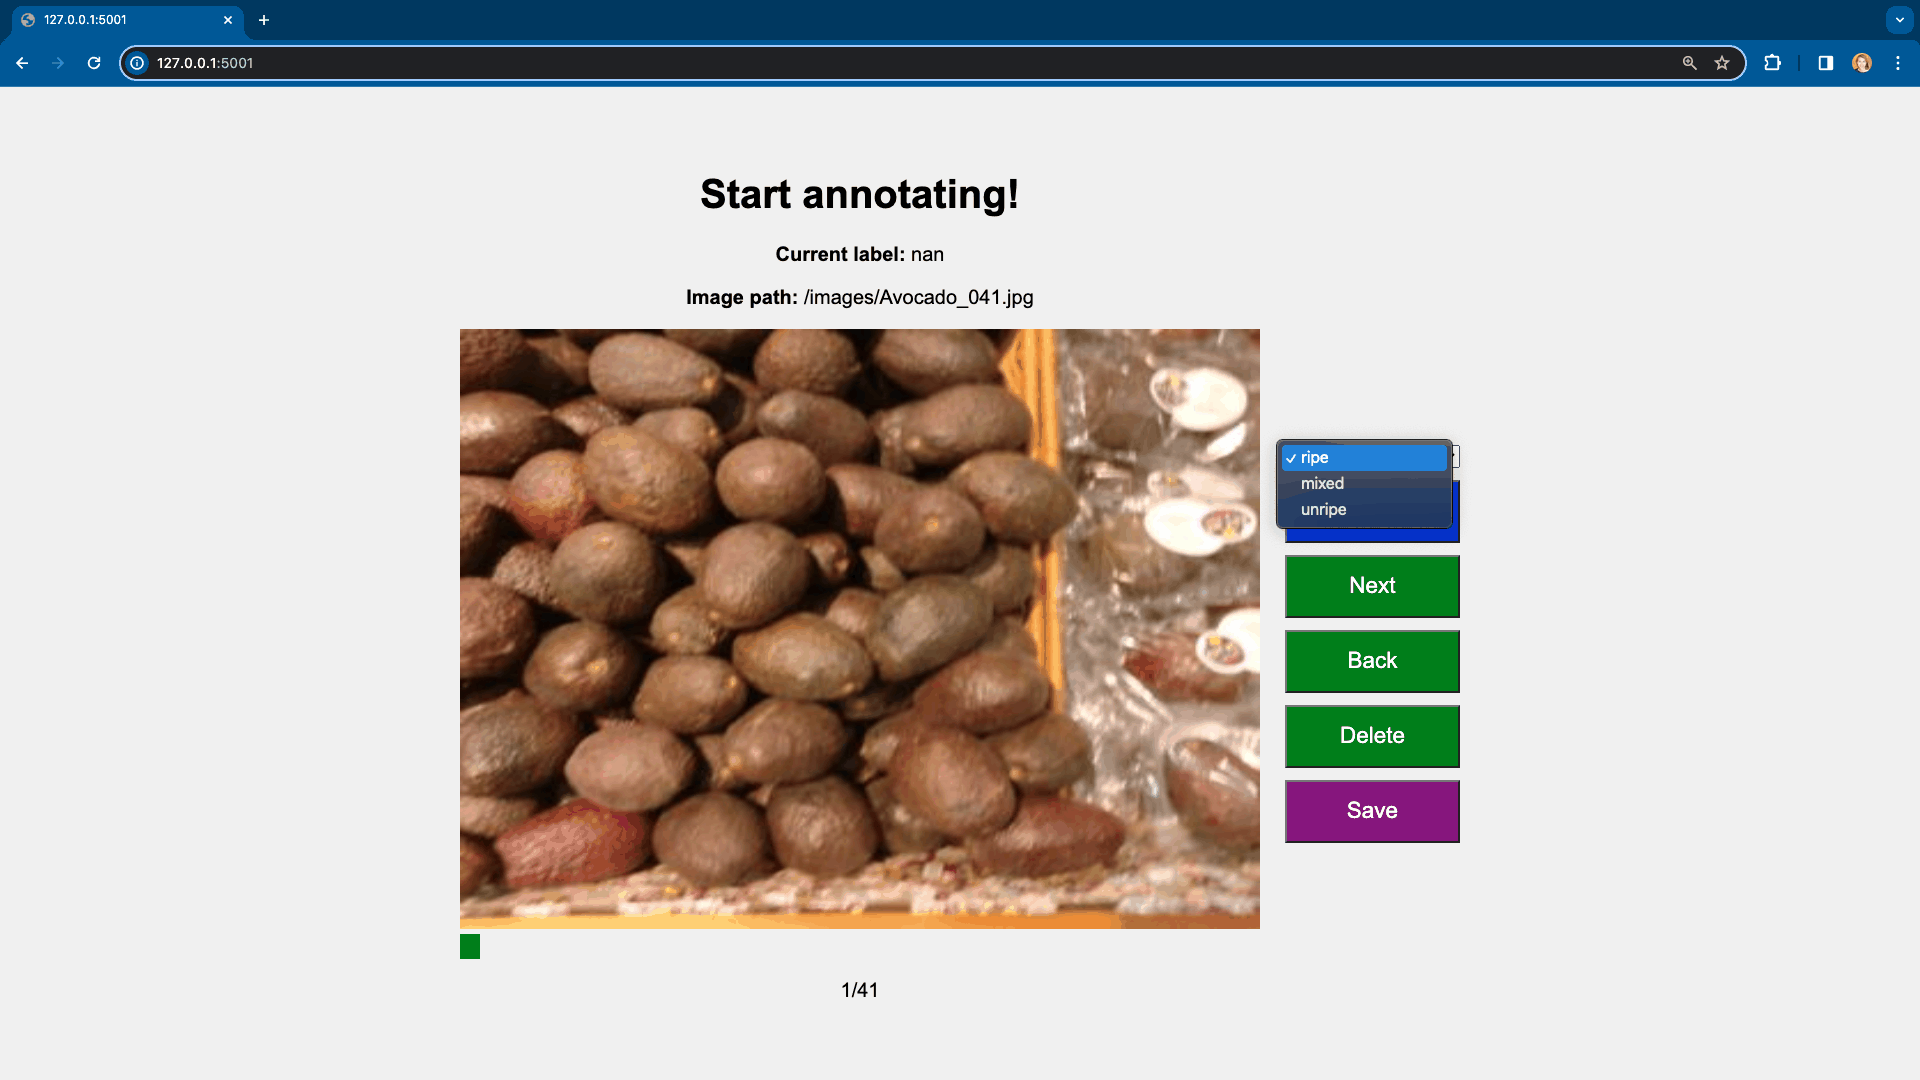

In [11]:
Image(filename="docs/avocado.gif")

# How to use the app

1. Use the drop-down menu to select the correct label.
2. Click "Update Label". You should see "Current Label" update near the top.
3. Click "Next" to move to the next image.
4. When you'd like to save your progress, click "Save". This will write out a new file `new_labels.csv` in your working directory with the updated labels.

You can also delete images if they are no longer relevant using the "Delete" button.

# Scenario 2: Scored Data

Let's say you've already labeled dozens of images, and you're tired. Can't you just train a model already?

This is where active learning comes in handy. Instead of laboriously labeling every image, you can train a model on a smaller dataset of labels. You can then use that model to predict the class of the remaining images and only label the images of which the model is least certain. You use those new labels as additional training data to help improve the model.

Let's train a model in DataRobot that identifies certain types of fruits. In your case, you'll use bananas, kiwis, pomegranates, and mangoes. 

In [12]:
classes = ["Banana", "Pomegranate", "Mango", "Kiwi"]

Set up some new directories to help organize your files.

In [ ]:
%%bash
mkdir images/fruit_classification
mkdir images/fruit_classification/fruit_images_for_labeling

## Set aside "unlabeled" data to label within your app

Move a subset of your images into a different folder and use them later for labeling. 

In [8]:
for c in classes:
    for filename in os.listdir(os.path.join("images/all_classes", c)):
        # need to remove the fruit name from the filename
        numeric_fn = filename.split("_")[-1]

        # if numeric filename is divisible by 5, move it
        if int(numeric_fn.split(".")[0]) % 5 == 0:
            print(f"Moving {filename} to scoring folder")
            # put it in a different folder for labeling
            os.rename(
                os.path.join("images/all_classes", c, filename),
                os.path.join(
                    "images/fruit_classification/fruit_images_for_labeling/",
                    f"{c[0]}_{numeric_fn}",
                ),
            )

Moving Banana_025.jpg to scoring folder
Moving Banana_030.jpg to scoring folder
Moving Banana_020.jpg to scoring folder
Moving Banana_035.jpg to scoring folder
Moving Banana_045.jpg to scoring folder
Moving Banana_040.jpg to scoring folder
Moving Banana_010.jpg to scoring folder
Moving Banana_005.jpg to scoring folder
Moving Banana_015.jpg to scoring folder
Moving Pomegranate_020.jpg to scoring folder
Moving Pomegranate_025.jpg to scoring folder
Moving Pomegranate_015.jpg to scoring folder
Moving Pomegranate_010.jpg to scoring folder
Moving Pomegranate_005.jpg to scoring folder
Moving Mango_015.jpg to scoring folder
Moving Mango_005.jpg to scoring folder
Moving Mango_010.jpg to scoring folder
Moving Mango_020.jpg to scoring folder
Moving Mango_030.jpg to scoring folder
Moving Mango_025.jpg to scoring folder
Moving Kiwi_005.jpg to scoring folder
Moving Kiwi_010.jpg to scoring folder
Moving Kiwi_015.jpg to scoring folder
Moving Kiwi_045.jpg to scoring folder
Moving Kiwi_040.jpg to scorin

## Create a DataRobot project

Now zip up the labeled fruit image data for DataRobot.

In [9]:
!zip -r images/fruit_classification/fruits.zip images/all_classes/Banana images/all_classes/Pomegranate images/all_classes/Mango images/all_classes/Kiwi

  adding: images/all_classes/Banana/ (stored 0%)
  adding: images/all_classes/Banana/Banana_026.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_032.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_033.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_027.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_019.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_031.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_024.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_018.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_034.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_008.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_009.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_021.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_023.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banana_037.jpg (deflated 1%)
  adding: images/all_classes/Banana/Banan

### Connect to DataRobot

Read more about [different options](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html) for connecting to DataRobot from the client.

In [15]:
# These variables can aso be fetched from a secret store or config files
DATAROBOT_ENDPOINT = "https://app.datarobot.com/api/v2"
# The URL may vary depending on your hosting preference, the above example is for DataRobot Managed AI Cloud

DATAROBOT_API_TOKEN = "<INSERT YOUR DataRobot API Token>"
# The API Token can be found by clicking the avatar icon and then </> Developer Tools

dr.Client(token=DATAROBOT_API_TOKEN, endpoint=DATAROBOT_ENDPOINT)

### Train a Visual AI model with DataRobot

In [16]:
# Create a dataset from the image dataset ZIP file
dataset = Dataset.create_from_file(file_path="images/fruit_classification/fruits.zip")

# Create a Visual AI project from the dataset
project = Project.create_from_dataset(
    dataset.id,
    project_name=f'Fruit Classification {datetime.now().strftime("%Y-%m-%d %H:%M")}',
)

# Set the project's target and initiate Autopilot
project.analyze_and_model(target="class", worker_count=-1, mode=dr.AUTOPILOT_MODE.QUICK)

# Wait for the model creation to finish
project.wait_for_autopilot()

In progress: 3, queued: 0 (waited: 0s)
In progress: 3, queued: 0 (waited: 1s)
In progress: 3, queued: 0 (waited: 1s)
In progress: 3, queued: 0 (waited: 2s)
In progress: 3, queued: 0 (waited: 4s)
In progress: 3, queued: 0 (waited: 6s)
In progress: 3, queued: 0 (waited: 10s)
In progress: 2, queued: 0 (waited: 17s)
In progress: 1, queued: 0 (waited: 30s)
In progress: 1, queued: 0 (waited: 51s)
In progress: 12, queued: 0 (waited: 71s)
In progress: 5, queued: 0 (waited: 92s)
In progress: 1, queued: 0 (waited: 113s)
In progress: 1, queued: 0 (waited: 133s)
In progress: 0, queued: 0 (waited: 154s)
In progress: 0, queued: 0 (waited: 175s)
In progress: 0, queued: 0 (waited: 196s)
In progress: 1, queued: 0 (waited: 216s)
In progress: 1, queued: 0 (waited: 237s)
In progress: 0, queued: 0 (waited: 257s)
In progress: 0, queued: 0 (waited: 278s)
In progress: 0, queued: 0 (waited: 299s)
In progress: 0, queued: 0 (waited: 319s)
In progress: 0, queued: 0 (waited: 340s)
In progress: 0, queued: 0 (waited

## Set up labeling dataset for the app

Now you need to create your dataframe containing relevant image information for the data annotation app. First, gather the paths to the images you set aside earlier.

In [17]:
path_to_scoring_data = "images/fruit_classification/fruit_images_for_labeling/"

df_scoring_imgs = pd.DataFrame(
    {
        "image_path": [
            os.path.join(path_to_scoring_data, fn)
            for fn in os.listdir(path_to_scoring_data)
        ]
    }
)
df_scoring_imgs.head()

image_path
0  images/fruit_classification/fruit_images_for_l...
1  images/fruit_classification/fruit_images_for_l...
2  images/fruit_classification/fruit_images_for_l...
3  images/fruit_classification/fruit_images_for_l...
4  images/fruit_classification/fruit_images_for_l...

You need to [encode your images to base64](https://www.datarobot.com/blog/getting-your-image-data-ready-for-visual-ai/) before sending them to the API.

In [18]:
df_scoring_imgs["image"] = get_encoded_image_contents_from_paths(
    df_scoring_imgs["image_path"]
)
df_scoring_imgs.head()

image_path  \
0  images/fruit_classification/fruit_images_for_l...   
1  images/fruit_classification/fruit_images_for_l...   
2  images/fruit_classification/fruit_images_for_l...   
3  images/fruit_classification/fruit_images_for_l...   
4  images/fruit_classification/fruit_images_for_l...   

                                               image  
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...  
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...  
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...  
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...  
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...

Now score these images using your top model on the leaderboard.

In [19]:
model = project.get_top_model()
predict_job = model.request_predictions(dataframe=df_scoring_imgs)
predictions = predict_job.get_result_when_complete()
predictions.head()

row_id   prediction  class_Banana  class_Kiwi  class_Mango  \
0       0        Mango      0.000007    0.002819     0.997156   
1       1        Mango      0.000242    0.000502     0.996657   
2       2  Pomegranate      0.000007    0.000117     0.004148   
3       3  Pomegranate      0.000021    0.001294     0.000184   
4       4        Mango      0.000115    0.000261     0.999442   

   class_Pomegranate  
0           0.000017  
1           0.002599  
2           0.995728  
3           0.998501  
4           0.000182

Let's put it all together so your app knows which image is matched with which prediction.

In [20]:
labeling_df = pd.concat([predictions, df_scoring_imgs], axis=1)
labeling_df["image_path"] = labeling_df["image_path"].apply(lambda x: x.split("/")[-1])
labeling_df.to_csv("fruit_predictions.csv", index=False)

## Call the app

You're ready to review the predictions in your app! This time you'll turn on the "smart sort" feature, which shows you the most uncertain predictions first. This allows you to maximize your impact while labeling.

In [21]:
%%bash
python app.py images/fruit_classification/fruit_images_for_labeling fruit_predictions.csv --smart_sort=True

 * Serving Flask app 'app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5001/ (Press CTRL+C to quit)
 * Restarting with watchdog (fsevents)
 * Debugger is active!
 * Debugger PIN: 328-123-525
127.0.0.1 - - [18/Jan/2024 16:20:37] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:20:37] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [18/Jan/2024 16:20:37] "GET /images/B_020.jpg HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:20:40] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:20:40] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [18/Jan/2024 16:20:40] "GET /images/B_020.jpg HTTP/1.1" 304 -
127.0.0.1 - - [18/Jan/2024 16:20:41] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:20:41] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [18/Jan/2024 16:20:41] "GET /images/P_005.jpg HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:20:43] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2024 16:20:43] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [18/Jan/2024 16:20:43] "GET /images/P_005.jpg HTTP/1.1" 304 

Error while terminating subprocess (pid=52018): 


You'll notice that the app now displays a `prediction` field and a new button: "Use Predicted Label". This allows you to set the predicted value as the correct label.

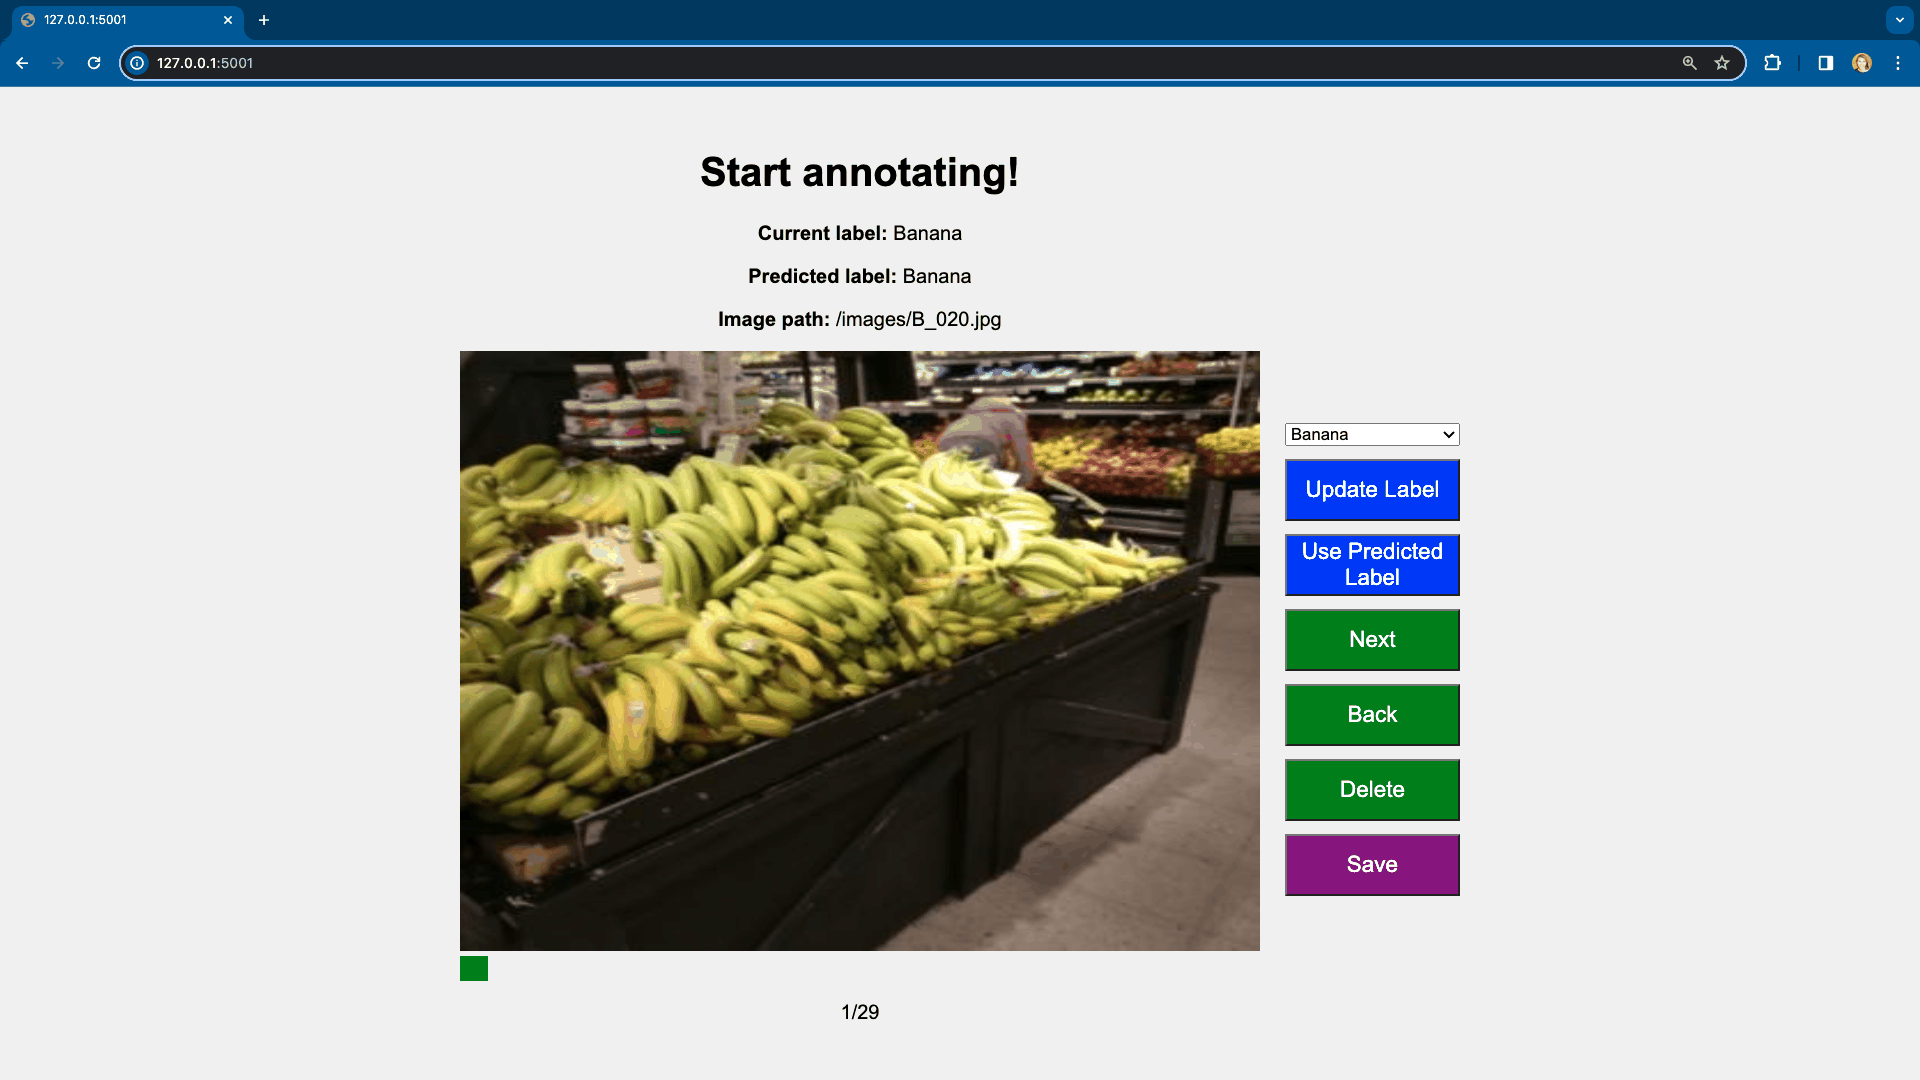

In [22]:
display(Image(filename="docs/fruits.gif"))

In this case, the model did very well on identifying fruits!